## Domain:
#### Ofsted rating is a manual process dependent on an ofsted inspector physically visiting the school. 
#### Schools are rated in four categories, 1.Outstanding 2. Good 3. Satisfactory 4. Inadequate
#### Osted can perform a limited number of visits per year(appr 1200 visits every year among  primary16000 schools), so they usually inspect 
- a 'satisfactory' school every 5 years(EDA shows much more) or so.
- a 'good' school every 3 years((EDA shows much more) or so.
- an 'oustanding' school, only when they receive a complaint

## Problem : 
#### A school can have an incorrect ofsted rating for many years, until a new inspection is carried out in who knows 5/10/15 years!!!
#### Ideal solution is to have school inspections every year for each school, but this will be very costly as we need physical school inspection.

## Solution : 
#### Predict ofsted ratings of schools, so that we identify schools, that need ofsted manual inspection the most.

## What does this notebook do?
- load data for primary schools that were ofsted inspected in year 2016-2017
- perform a test-train split on 2016-2017 data.
- baseline model score to predict ofsted ratings
- perform gridsearch on 3 different models with various scorers
- display/plot the scores/metrics of all models for the test data from 2016-2017.
- identify best model, and draw conculsions.
- Bonus: 
 - test how these models perform on year 2015-2016 and 2017-2018 data.
 - display/plot the scores/metrics of all models for 2015-2016 and 2017-2018 data.
 - Testing the solution : identify schools that need ofsted manual inspection the most, for for 2015-2016 and 2017-2018.

## Conclusion : 
- To classify a school as outstanding(1) or inadequate(4) with reduced feature set
 - we can see "LogisticRegression'>_minority_class_recall_score" model works the best with i.e. {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
 - it has a minority_class_recall_score of 82.55%. 
- With this model, we can identify the schools that need the ofsted physical inspection the most
 - i.e. the schools whose current and predicted ofsted differs a lot
 - e.g. a school with current_ofsted=1 and predicted_ofsted=4 needs ofsted physical inspection the most

#### Note :
- minority_class_recall_score = we have identified x% of the school that fall in category 1 or 4. i.e. 
- we have used feature redcution here, using regularization run in an earlier notebook. We noticed overall recall went up but minority_class_recall_score went down. so this is not the best model/feature
- baseline model had minority_class_recall_score: 34.13%

In [1]:
%run import_util.py
import scan_api
import util

START loading util functions
DONE loading util functions


## Load data for schools that were ofsted inspected in year 2016-2017

In [2]:
## parameters that you might want to reset in the notebook

# util.np.random.seed(42)
# util.trace=False
util.debug=True
# util.info=True
# util.multiclass=True
# util.upsample=True

# util.myscorers = [
#     util.multiclass_accuracy_score,
#     util.multiclass_recall_score,
#     util.multiclass_f1_score,
#     util.minority_class_recall_score,
#     util.poor_class_recall_score
# ]
n=2

In [3]:
# based on EDA, we found 600+ school data missing total_income, total_expenditure,free_school_meal_band . So we should drop them from the feature set
# based on regularization, we found only these features useful

# set features and target
features=['readprog', 'ptread_exp','ptread_high', 'read_average', 
          'writeprog', 'ptgps_exp', 'ptgps_high','gps_average', 
          'matprog', 'ptmat_exp', 'ptmat_high', 'ptmat_average']

target="ofsted"

all=['URN']+features+['ofsted']

In [4]:
# We have three years of school data
start=['2016','2015','2017']
end=['2017','2016','2018']

# we are loading 2016_2017 data, and mdoelling on it
util.data_directory="./data/"+start[0]+"-"+end[0]+"/"
df=util.read_file("cleanData1.csv")
df.head(n)

,URN,abscence,persitent_abscence,total_pupils,girls_perc,english_nfl,free_school_meal,is_london,total_income,total_expenditure,...,ptgps_exp,ptgps_high,gps_average,matprog,ptmat_exp,ptmat_high,ptmat_average,ofsted,pub_date,ofsted_phase
0,100000,2.5,2.8,276.0,49.3,59.3,12.0,True,8176.0,8319.0,...,92.0,50.0,109.0,3.1,92.0,38.0,107.0,1.0,2013-04-19,Primary
1,136807,3.8,6.5,92.0,44.6,59.7,13.0,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2013-07-04,Primary


In [5]:
display(df.shape)
display(df['ofsted'].value_counts())

# filter out schools which were ofsted inspected this year
df['pub_date'] = df.pub_date.apply(util.convert_to_datetime) 
df.dropna(axis=0, how='any', subset=['pub_date'],inplace=True)
start_date = datetime.strptime(start[0]+'-08-01', '%Y-%m-%d')
end_date = datetime.strptime(end[0]+'-07-30', '%Y-%m-%d')
df = df[ (df['pub_date']>start_date) & (df['pub_date']<end_date) ]

# convert boolean feature to float
df['is_london'].replace(True, 1,inplace=True)
df['is_london'].replace(False, 0,inplace=True)

display(df.shape)
display(df['ofsted'].value_counts())

(16785, 37)

2.0    11576
1.0     3063
3.0     1333
4.0      214
Name: ofsted, dtype: int64

(2006, 37)

2.0    943
3.0    736
4.0    166
1.0    161
Name: ofsted, dtype: int64

In [6]:
#  drop all rows which have NAN 

df = df[all]

display(df.shape)
display(df['ofsted'].value_counts())
df.dropna(axis=0, how='any',inplace=True)
display(df.shape)
display(df['ofsted'].value_counts())

display(df.isnull().sum())
df.head(n)

(2006, 14)

2.0    943
3.0    736
4.0    166
1.0    161
Name: ofsted, dtype: int64

(1741, 14)

2.0    803
3.0    646
4.0    150
1.0    142
Name: ofsted, dtype: int64

URN              0
readprog         0
ptread_exp       0
ptread_high      0
read_average     0
writeprog        0
ptgps_exp        0
ptgps_high       0
gps_average      0
matprog          0
ptmat_exp        0
ptmat_high       0
ptmat_average    0
ofsted           0
dtype: int64

,URN,readprog,ptread_exp,ptread_high,read_average,writeprog,ptgps_exp,ptgps_high,gps_average,matprog,ptmat_exp,ptmat_high,ptmat_average,ofsted
38,100044,1.6,69.0,12.0,104.0,1.8,96.0,62.0,110.0,4.8,96.0,27.0,107.0,2.0
83,100168,5.4,100.0,56.0,111.0,1.5,97.0,63.0,111.0,2.9,91.0,38.0,108.0,1.0


In [7]:
# if the modelling is to be done on binary label, convert multiclass to binary
if not util.multiclass:
    display(df.shape)
    display(df['ofsted'].value_counts())
    
    df['ofsted'].replace([1, 2], 1,inplace=True)
    df['ofsted'].replace([3, 4], 0,inplace=True)

    display(df.shape)
    display(df['ofsted'].value_counts())

## Perform a test-train split on 2016-2017 data.

In [8]:
X = df[features]
y = df[target].values

#scale features, by default target is not scaled
#note:stratify=y
scalerX, scalery, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = util.split_scale_df(X,y,stratify=y)

display(pd.DataFrame(y_train_scaled,columns=['ofsted'])['ofsted'].value_counts())

2.0    602
3.0    484
4.0    112
1.0    107
Name: ofsted, dtype: int64

In [9]:
# upsample_minority_class 
if util.upsample:
    new_df=X_train_scaled.copy()
    new_df[target]=y_train_scaled
    if util.multiclass:
        new_df = util.upsample_minority_class_multiclass(new_df)
    else:
        new_df = util.upsample_minority_class_binary(new_df)
    X_train_scaled = new_df[features]
    y_train_scaled = new_df[target].values

2.0    602
3.0    484
4.0    112
1.0    107
Name: ofsted, dtype: int64
2.0    602
4.0    560
1.0    535
3.0    484
Name: ofsted, dtype: int64


In [10]:
df.head(n)

,URN,readprog,ptread_exp,ptread_high,read_average,writeprog,ptgps_exp,ptgps_high,gps_average,matprog,ptmat_exp,ptmat_high,ptmat_average,ofsted
38,100044,1.6,69.0,12.0,104.0,1.8,96.0,62.0,110.0,4.8,96.0,27.0,107.0,2.0
83,100168,5.4,100.0,56.0,111.0,1.5,97.0,63.0,111.0,2.9,91.0,38.0,108.0,1.0


## Baseline model score to predict ofsted ratings

In [11]:
from sklearn.dummy import DummyClassifier

print("baseline metrics using DummyClassifier")
for new_strategy in ["most_frequent","stratified","uniform","prior"]:
    dummy_classifier = DummyClassifier(strategy=new_strategy)
    dummy_classifier.fit( X_train_scaled,y_train_scaled )
    print(f"{new_strategy} based score : {dummy_classifier.score(X_test_scaled, y_test_scaled)}")
    y_test_pred=dummy_classifier.predict(X_test_scaled)
    to_print=""
    for my_scorer in util.myscorers:
        scorer_str=(str(my_scorer).split(" ")[1])
        to_print=f"test {scorer_str}: {my_scorer(y_test_scaled, y_test_pred)}"+ ", " + to_print
    util.printmd(to_print)

baseline metrics using DummyClassifier
most_frequent based score : 0.4610091743119266


<span style='color:blue'>test poor_class_recall_score: 0.0, test minority_class_recall_score: 0.0, test multiclass_f1_score: 0.631083202511774, test multiclass_recall_score: 0.25, test multiclass_accuracy_score: 0.4610091743119266, </span>

stratified based score : 0.24541284403669725


<span style='color:blue'>test poor_class_recall_score: 0.2894736842105263, test minority_class_recall_score: 0.2733082706766917, test multiclass_f1_score: 0.22314855662728542, test multiclass_recall_score: 0.2599727275624107, test multiclass_accuracy_score: 0.25229357798165136, </span>

uniform based score : 0.24770642201834864


<span style='color:blue'>test poor_class_recall_score: 0.3684210526315789, test minority_class_recall_score: 0.34135338345864663, test multiclass_f1_score: 0.2433931944602081, test multiclass_recall_score: 0.29853278165008984, test multiclass_accuracy_score: 0.26605504587155965, </span>

prior based score : 0.4610091743119266


<span style='color:blue'>test poor_class_recall_score: 0.0, test minority_class_recall_score: 0.0, test multiclass_f1_score: 0.631083202511774, test multiclass_recall_score: 0.25, test multiclass_accuracy_score: 0.4610091743119266, </span>

## Perform gridsearch on 3 different models with various scorers

In [12]:
# Run knn, log_reg and random_forest on various scorers
i=0
df_plot= pd.DataFrame(columns=['model_name','scorer','scores'])
grids = {}
# trace=True
# debug=True
for estimator in [KNeighborsClassifier(),
                   LogisticRegression(multi_class='ovr',max_iter=100),
                   RandomForestClassifier()]:
    for my_scorer in util.myscorers:
        scorer_str=str(my_scorer).split(" ")[1]
        estimator_str=str(type(estimator)).split(".")[3]
        run_name=estimator_str+"_"+scorer_str
        print(run_name)
        grid, y_test, y_test_pred = util.classifier_gridsearchcv(X_train_scaled, 
                                                      X_test_scaled,
                                                      y_train_scaled,
                                                      y_test_scaled,
                                                      estimator,scorer=util.make_scorer(my_scorer))
        for my_scorer1 in util.myscorers:
            scorer_str1=str(my_scorer1).split(" ")[1]
            df_plot.loc[i] = [estimator_str+":"+scorer_str,
                              scorer_str1,
                              my_scorer1(y_test,y_test_pred)*100]
            i=i+1
        
        grids[run_name]= (grid, y_test, y_test_pred)

# trace=False
# debug=False

KNeighborsClassifier'>_multiclass_accuracy_score
best_estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
best estimator score: 0.6593305823016965,best params: {'n_neighbors': 3}
train poor_class_recall_score: 0.9910714285714286, train minority_class_recall_score: 0.9955357142857143, train multiclass_f1_score: 0.7983541000646681, train multiclass_recall_score: 0.807891137667829, train multiclass_accuracy_score: 0.8110958276020174, 


<span style='color:blue'>test poor_class_recall_score: 0.21052631578947367, test minority_class_recall_score: 0.262406015037594, test multiclass_f1_score: 0.31904459656202905, test multiclass_recall_score: 0.33882231837193866, test multiclass_accuracy_score: 0.3922018348623853, </span>

KNeighborsClassifier'>_multiclass_recall_score
best_estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
best estimator score: 0.6547985400856648,best params: {'n_neighbors': 3}
train poor_class_recall_score: 0.9910714285714286, train minority_class_recall_score: 0.9955357142857143, train multiclass_f1_score: 0.7983541000646681, train multiclass_recall_score: 0.807891137667829, train multiclass_accuracy_score: 0.8110958276020174, 


<span style='color:blue'>test poor_class_recall_score: 0.21052631578947367, test minority_class_recall_score: 0.262406015037594, test multiclass_f1_score: 0.31904459656202905, test multiclass_recall_score: 0.33882231837193866, test multiclass_accuracy_score: 0.3922018348623853, </span>

KNeighborsClassifier'>_multiclass_f1_score
best_estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
best estimator score: 0.6263468258834525,best params: {'n_neighbors': 3}
train poor_class_recall_score: 0.9910714285714286, train minority_class_recall_score: 0.9955357142857143, train multiclass_f1_score: 0.7983541000646681, train multiclass_recall_score: 0.807891137667829, train multiclass_accuracy_score: 0.8110958276020174, 


<span style='color:blue'>test poor_class_recall_score: 0.21052631578947367, test minority_class_recall_score: 0.262406015037594, test multiclass_f1_score: 0.31904459656202905, test multiclass_recall_score: 0.33882231837193866, test multiclass_accuracy_score: 0.3922018348623853, </span>

KNeighborsClassifier'>_minority_class_recall_score
best_estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
best estimator score: 0.9436395282587384,best params: {'n_neighbors': 3}
train poor_class_recall_score: 0.9910714285714286, train minority_class_recall_score: 0.9955357142857143, train multiclass_f1_score: 0.7983541000646681, train multiclass_recall_score: 0.807891137667829, train multiclass_accuracy_score: 0.8110958276020174, 


<span style='color:blue'>test poor_class_recall_score: 0.21052631578947367, test minority_class_recall_score: 0.262406015037594, test multiclass_f1_score: 0.31904459656202905, test multiclass_recall_score: 0.33882231837193866, test multiclass_accuracy_score: 0.3922018348623853, </span>

KNeighborsClassifier'>_poor_class_recall_score
best_estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
best estimator score: 0.932124844435711,best params: {'n_neighbors': 3}
train poor_class_recall_score: 0.9910714285714286, train minority_class_recall_score: 0.9955357142857143, train multiclass_f1_score: 0.7983541000646681, train multiclass_recall_score: 0.807891137667829, train multiclass_accuracy_score: 0.8110958276020174, 


<span style='color:blue'>test poor_class_recall_score: 0.21052631578947367, test minority_class_recall_score: 0.262406015037594, test multiclass_f1_score: 0.31904459656202905, test multiclass_recall_score: 0.33882231837193866, test multiclass_accuracy_score: 0.3922018348623853, </span>

LogisticRegression'>_multiclass_accuracy_score
best_estimator: LogisticRegression(C=0.021544346900318832, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
best estimator score: 0.5167354424575883,best params: {'C': 0.021544346900318832, 'penalty': 'l1', 'solver': 'liblinear'}
train poor_class_recall_score: 0.7571428571428571, train minority_class_recall_score: 0.815954606141522, train multiclass_f1_score: 0.4298811199120796, train multiclass_recall_score: 0.5059839475890334, train multiclass_accuracy_score: 0.517193947730399, 
intercept: [-1.58485117 -0.87102087 -1.14889339 -1.10694087], coefIndex(['readprog', 'ptread_exp', 'ptread_high', 'read_average', 'writeprog',
       'ptgps_exp', 'ptgps_high', 'gps_average', 'matprog', 'ptmat_exp',
       'ptmat_high', 'ptmat_average'],
      dtype='object

<span style='color:blue'>test poor_class_recall_score: 0.7368421052631579, test minority_class_recall_score: 0.8112781954887218, test multiclass_f1_score: 0.33730841264380995, test multiclass_recall_score: 0.48399730669958474, test multiclass_accuracy_score: 0.2798165137614679, </span>

LogisticRegression'>_multiclass_recall_score
best_estimator: LogisticRegression(C=0.021544346900318832, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
best estimator score: 0.5059752542382487,best params: {'C': 0.021544346900318832, 'penalty': 'l1', 'solver': 'liblinear'}
train poor_class_recall_score: 0.7571428571428571, train minority_class_recall_score: 0.815954606141522, train multiclass_f1_score: 0.4298811199120796, train multiclass_recall_score: 0.5059839475890334, train multiclass_accuracy_score: 0.517193947730399, 
intercept: [-1.58477455 -0.87102269 -1.14889558 -1.10696133], coefIndex(['readprog', 'ptread_exp', 'ptread_high', 'read_average', 'writeprog',
       'ptgps_exp', 'ptgps_high', 'gps_average', 'matprog', 'ptmat_exp',
       'ptmat_high', 'ptmat_average'],
      dtype='object')

<span style='color:blue'>test poor_class_recall_score: 0.7368421052631579, test minority_class_recall_score: 0.8112781954887218, test multiclass_f1_score: 0.33730841264380995, test multiclass_recall_score: 0.48399730669958474, test multiclass_accuracy_score: 0.2798165137614679, </span>

LogisticRegression'>_multiclass_f1_score
best_estimator: LogisticRegression(C=0.004641588833612777, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
best estimator score: 0.5197683913805903,best params: {'C': 0.004641588833612777, 'penalty': 'l1', 'solver': 'liblinear'}
train poor_class_recall_score: 0.7357142857142858, train minority_class_recall_score: 0.8108477970627503, train multiclass_f1_score: 0.5348397889682187, train multiclass_recall_score: 0.48225114105629213, train multiclass_accuracy_score: 0.49105914718019256, 
intercept: [-0.72503324 -0.51165531 -0.75056354 -0.6028124 ], coefIndex(['readprog', 'ptread_exp', 'ptread_high', 'read_average', 'writeprog',
       'ptgps_exp', 'ptgps_high', 'gps_average', 'matprog', 'ptmat_exp',
       'ptmat_high', 'ptmat_average'],
      dtype='object')

<span style='color:blue'>test poor_class_recall_score: 0.7105263157894737, test minority_class_recall_score: 0.7838345864661653, test multiclass_f1_score: 0.2910101667927792, test multiclass_recall_score: 0.4503750046758688, test multiclass_accuracy_score: 0.23853211009174313, </span>

LogisticRegression'>_minority_class_recall_score
best_estimator: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
best estimator score: 0.8725809910639581,best params: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
train poor_class_recall_score: 0.8178571428571428, train minority_class_recall_score: 0.8762182910547396, train multiclass_f1_score: 0.33845009780761004, train multiclass_recall_score: 0.4592885475207253, train multiclass_accuracy_score: 0.4626318202659331, 
intercept: [-0.39025393 -0.31962958 -0.39279716 -0.34770296], coefIndex(['readprog', 'ptread_exp', 'ptread_high', 'read_average', 'writeprog',
       'ptgps_exp', 'ptgps_high', 'gps_average', 'matprog', 'ptmat_exp',
       'ptmat_high', 'ptmat_average'],
      dtype='object') : [[ 0.0906333   0.101

<span style='color:blue'>test poor_class_recall_score: 0.7368421052631579, test minority_class_recall_score: 0.825563909774436, test multiclass_f1_score: 0.20161423169230094, test multiclass_recall_score: 0.4277073280215464, test multiclass_accuracy_score: 0.1651376146788991, </span>

LogisticRegression'>_poor_class_recall_score
best_estimator: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
best estimator score: 0.812490993646427,best params: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
train poor_class_recall_score: 0.8178571428571428, train minority_class_recall_score: 0.8762182910547396, train multiclass_f1_score: 0.33845009780761004, train multiclass_recall_score: 0.4592885475207253, train multiclass_accuracy_score: 0.4626318202659331, 
intercept: [-0.39025393 -0.31962958 -0.39279716 -0.34770296], coefIndex(['readprog', 'ptread_exp', 'ptread_high', 'read_average', 'writeprog',
       'ptgps_exp', 'ptgps_high', 'gps_average', 'matprog', 'ptmat_exp',
       'ptmat_high', 'ptmat_average'],
      dtype='object') : [[ 0.0906333   0.10116038

<span style='color:blue'>test poor_class_recall_score: 0.7368421052631579, test minority_class_recall_score: 0.825563909774436, test multiclass_f1_score: 0.20161423169230094, test multiclass_recall_score: 0.4277073280215464, test multiclass_accuracy_score: 0.1651376146788991, </span>

RandomForestClassifier'>_multiclass_accuracy_score
best_estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
best estimator score: 0.6840898670334709,best params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 17}
train poor_class_recall_score: 0.9892857142857143, train minority_class_recall_score: 0.9918391188251001, train multiclass_f1_score: 0.8532931992603263, train multiclass_recall_score: 0.8567862297401083, train multiclass_accuracy_score: 0.859697386519945, 


<span style='color:blue'>test poor_class_recall_score: 0.34210526315789475, test minority_class_recall_score: 0.4710526315789474, test multiclass_f1_score: 0.4049799562856851, test multiclass_recall_score: 0.455583437587889, test multiclass_accuracy_score: 0.44954128440366975, </span>

RandomForestClassifier'>_multiclass_recall_score
best_estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
best estimator score: 0.6805962967476065,best params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 19}
train poor_class_recall_score: 0.9803571428571428, train minority_class_recall_score: 0.9827019359145528, train multiclass_f1_score: 0.8543769466728799, train multiclass_recall_score: 0.8567960408547806, train multiclass_accuracy_score: 0.8606143970655663, 


<span style='color:blue'>test poor_class_recall_score: 0.2631578947368421, test minority_class_recall_score: 0.3744360902255639, test multiclass_f1_score: 0.3996300456425616, test multiclass_recall_score: 0.4265307408931394, test multiclass_accuracy_score: 0.46788990825688076, </span>

RandomForestClassifier'>_multiclass_f1_score
best_estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
best estimator score: 0.6738506036057376,best params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 21}
train poor_class_recall_score: 0.9785714285714285, train minority_class_recall_score: 0.9818090787716955, train multiclass_f1_score: 0.8586939534817855, train multiclass_recall_score: 0.8610893228898702, train multiclass_accuracy_score: 0.8638239339752407, 


<span style='color:blue'>test poor_class_recall_score: 0.3157894736842105, test minority_class_recall_score: 0.4007518796992481, test multiclass_f1_score: 0.37524525833878347, test multiclass_recall_score: 0.4127170122653233, test multiclass_accuracy_score: 0.42660550458715596, </span>

RandomForestClassifier'>_minority_class_recall_score
best_estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
best estimator score: 0.9335423375927346,best params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 21}
train poor_class_recall_score: 0.9642857142857143, train minority_class_recall_score: 0.9784045393858478, train multiclass_f1_score: 0.8656949678085617, train multiclass_recall_score: 0.867176172111858, train multiclass_accuracy_score: 0.8707015130674003, 


<span style='color:blue'>test poor_class_recall_score: 0.34210526315789475, test minority_class_recall_score: 0.4139097744360902, test multiclass_f1_score: 0.3918725986163445, test multiclass_recall_score: 0.42795636132897197, test multiclass_accuracy_score: 0.4426605504587156, </span>

RandomForestClassifier'>_poor_class_recall_score
best_estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
best estimator score: 0.9303759743237048,best params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 21}
train poor_class_recall_score: 0.9732142857142857, train minority_class_recall_score: 0.9838034045393859, train multiclass_f1_score: 0.8685137768160728, train multiclass_recall_score: 0.8703818373565932, train multiclass_accuracy_score: 0.8734525447042641, 


<span style='color:blue'>test poor_class_recall_score: 0.23684210526315788, test minority_class_recall_score: 0.33270676691729323, test multiclass_f1_score: 0.3780604858499764, test multiclass_recall_score: 0.3988483162023356, test multiclass_accuracy_score: 0.44954128440366975, </span>

## Display/plot the scores/metrics of all models for the test data from 2016-2017.

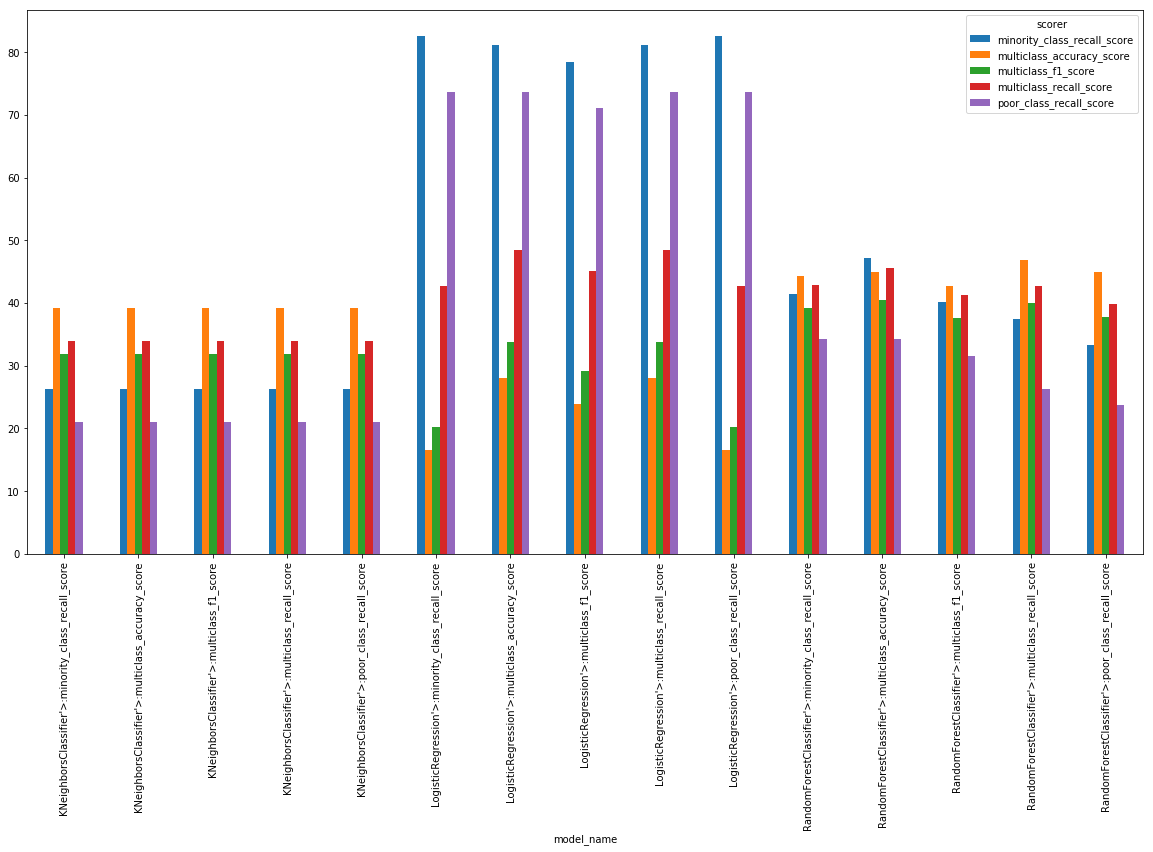

In [13]:
# display test data scores of various best models  
df1 = df_plot.pivot(index='model_name', columns='scorer', values='scores')
df1.plot(kind='bar',figsize=(20, 10))

In [14]:
# display test confusion matrix of various best models  
for gridName,gridValues in grids.items():
    print(gridName)
    grid, y_test, y_test_pred = gridValues
    display(pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))


KNeighborsClassifier'>_multiclass_accuracy_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,11,20,4,0,35
2.0,39,90,52,20,201
3.0,12,54,62,34,162
4.0,5,11,14,8,38
All,67,175,132,62,436


KNeighborsClassifier'>_multiclass_recall_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,11,20,4,0,35
2.0,39,90,52,20,201
3.0,12,54,62,34,162
4.0,5,11,14,8,38
All,67,175,132,62,436


KNeighborsClassifier'>_multiclass_f1_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,11,20,4,0,35
2.0,39,90,52,20,201
3.0,12,54,62,34,162
4.0,5,11,14,8,38
All,67,175,132,62,436


KNeighborsClassifier'>_minority_class_recall_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,11,20,4,0,35
2.0,39,90,52,20,201
3.0,12,54,62,34,162
4.0,5,11,14,8,38
All,67,175,132,62,436


KNeighborsClassifier'>_poor_class_recall_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,11,20,4,0,35
2.0,39,90,52,20,201
3.0,12,54,62,34,162
4.0,5,11,14,8,38
All,67,175,132,62,436


LogisticRegression'>_multiclass_accuracy_score


Predicted,1.0,2.0,4.0,All
Actual,,,,
1.0,31,3,1,35
2.0,75,63,63,201
3.0,24,52,86,162
4.0,6,4,28,38
All,136,122,178,436


LogisticRegression'>_multiclass_recall_score


Predicted,1.0,2.0,4.0,All
Actual,,,,
1.0,31,3,1,35
2.0,75,63,63,201
3.0,24,52,86,162
4.0,6,4,28,38
All,136,122,178,436


LogisticRegression'>_multiclass_f1_score


Predicted,1.0,2.0,4.0,All
Actual,,,,
1.0,30,3,2,35
2.0,93,47,61,201
3.0,29,48,85,162
4.0,7,4,27,38
All,159,102,175,436


LogisticRegression'>_minority_class_recall_score


Predicted,1.0,2.0,4.0,All
Actual,,,,
1.0,32,1,2,35
2.0,113,12,76,201
3.0,48,15,99,162
4.0,9,1,28,38
All,202,29,205,436


LogisticRegression'>_poor_class_recall_score


Predicted,1.0,2.0,4.0,All
Actual,,,,
1.0,32,1,2,35
2.0,113,12,76,201
3.0,48,15,99,162
4.0,9,1,28,38
All,202,29,205,436


RandomForestClassifier'>_multiclass_accuracy_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,21,14,0,0,35
2.0,37,100,47,17,201
3.0,10,57,62,33,162
4.0,1,10,14,13,38
All,69,181,123,63,436


RandomForestClassifier'>_multiclass_recall_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,17,17,1,0,35
2.0,28,113,42,18,201
3.0,10,58,64,30,162
4.0,0,10,18,10,38
All,55,198,125,58,436


RandomForestClassifier'>_multiclass_f1_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,17,14,3,1,35
2.0,38,100,42,21,201
3.0,7,71,57,27,162
4.0,2,10,14,12,38
All,64,195,116,61,436


RandomForestClassifier'>_minority_class_recall_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,17,16,1,1,35
2.0,38,102,43,18,201
3.0,6,67,61,28,162
4.0,0,11,14,13,38
All,61,196,119,60,436


RandomForestClassifier'>_poor_class_recall_score


Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,15,18,1,1,35
2.0,30,110,48,13,201
3.0,9,66,62,25,162
4.0,1,12,16,9,38
All,55,206,127,48,436


In [15]:
# display test data stats of various best models  

for gridName,gridValues in grids.items():
    print(gridName)
    grid, y_test, y_test_pred = gridValues
    print(classification_report(y_test,y_test_pred))

KNeighborsClassifier'>_multiclass_accuracy_score
              precision    recall  f1-score   support

         1.0       0.16      0.31      0.22        35
         2.0       0.51      0.45      0.48       201
         3.0       0.47      0.38      0.42       162
         4.0       0.13      0.21      0.16        38

   micro avg       0.39      0.39      0.39       436
   macro avg       0.32      0.34      0.32       436
weighted avg       0.44      0.39      0.41       436

KNeighborsClassifier'>_multiclass_recall_score
              precision    recall  f1-score   support

         1.0       0.16      0.31      0.22        35
         2.0       0.51      0.45      0.48       201
         3.0       0.47      0.38      0.42       162
         4.0       0.13      0.21      0.16        38

   micro avg       0.39      0.39      0.39       436
   macro avg       0.32      0.34      0.32       436
weighted avg       0.44      0.39      0.41       436

KNeighborsClassifier'>_multiclass_

## Identify best model, and draw conculsions.

In [16]:
# conclusion: 
# To classify a school as outstanding(1) or inadequate(4)
# we can see "LogisticRegression'>_minority_class_recall_score" model works the best with an recall of 82.55%, {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}

# With this model, we can identify the schools that need the ofsted physical inspection the most
# i.e. the schools whose current and predicted ofsted differs a lot
# e.g. a school with current_ofsted=1 and predicted_ofsted=4 needs ofsted physical inspection the most

# Notes:
# recal_minority_class_recall_score = we have identified x% of the school that fall in category 1 or 4. i.e. 
# we have used feature redcution here, using regularization run in an earlier notebook.

## Bonus : Test how these models perform on year 2015-2016 and 2017-2018 data.

In [17]:
# calculate test data scores for other years by running our best models on them

df_plots={}
df_school_visit_plots={}
for i in [1,2]:
    util.data_directory="./data/"+start[i]+"-"+end[i]+"/" 
    util.printmd(f"stats for {util.data_directory}")
    df1 = pd.read_csv(util.data_directory + "cleanData1.csv")

    df1['pub_date'] = df1.pub_date.apply(util.convert_to_datetime) 
    df1.dropna(axis=0, how='any', subset=['pub_date'],inplace=True)
    start_date = datetime.strptime(start[i]+'-08-01', '%Y-%m-%d')
    end_date = datetime.strptime(end[i]+'-07-30', '%Y-%m-%d')
    df1 = df1[ (df1['pub_date']>start_date) & (df1['pub_date']<end_date) ]
    
    if not util.multiclass:
        df1['ofsted'].replace([1, 2], 1,inplace=True)
        df1['ofsted'].replace([3, 4], 0,inplace=True)
            
    df1 = df1[all]
    df1.dropna(axis=0, how='any',inplace=True)
    display(df1['ofsted'].value_counts())
    display(df1.shape)

    X1 = df1[features]
    y1 = df1[target].values

    X1_test_scaled = pd.DataFrame(scalerX.transform(X1), index=X1.index, columns=X1.columns)
    y1_test_scaled = y1

    predicted_school_df={}
    count=0
    df_plot1= pd.DataFrame(columns=['model_name','scorer','scores'])
    for gridName,gridValues in grids.items():
        print(f"stats for {gridName}")
        grid, y_test, y_test_pred = gridValues
        y1_test_pred = grid.best_estimator_.predict(X1_test_scaled)
        new_df=df1[['URN',target]].copy()
        new_df['ofsted_predicted']=y1_test_pred
        predicted_school_df[gridName]=new_df
        print(f"best_estimator_.score: {grid.best_estimator_.score(X1_test_scaled, y1_test_scaled)}")
        
        to_print=""
        for my_scorer in util.myscorers:
            scorer_str=(str(my_scorer).split(" ")[1])
            to_print=f"test {scorer_str}: {my_scorer(y1_test_scaled, y1_test_pred)}"+ ", " + to_print
            df_plot1.loc[count] = [gridName,
                          scorer_str,
                          my_scorer(y1_test_scaled,y1_test_pred)*100]
            count=count+1
        
        util.printmd(to_print)   
        display(pd.crosstab(y1_test_scaled, y1_test_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
        print(classification_report(y1_test_scaled,y1_test_pred))
    df_plots[start[i]+"-"+end[i]]=df_plot1
    df_school_visit_plots[start[i]+"-"+end[i]]=predicted_school_df

<span style='color:blue'>stats for ./data/2015-2016/</span>

2.0    933
3.0    388
1.0    132
4.0     99
Name: ofsted, dtype: int64

(1552, 14)

stats for KNeighborsClassifier'>_multiclass_accuracy_score
best_estimator_.score: 0.3949742268041237


<span style='color:blue'>test poor_class_recall_score: 0.42424242424242425, test minority_class_recall_score: 0.35984848484848486, test multiclass_f1_score: 0.32912638905071107, test multiclass_recall_score: 0.3774262037285374, test multiclass_accuracy_score: 0.3949742268041237, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,39,64,17,12,132
2.0,99,386,307,141,933
3.0,19,133,146,90,388
4.0,2,23,32,42,99
All,159,606,502,285,1552


              precision    recall  f1-score   support

         1.0       0.25      0.30      0.27       132
         2.0       0.64      0.41      0.50       933
         3.0       0.29      0.38      0.33       388
         4.0       0.15      0.42      0.22        99

   micro avg       0.39      0.39      0.39      1552
   macro avg       0.33      0.38      0.33      1552
weighted avg       0.49      0.39      0.42      1552

stats for KNeighborsClassifier'>_multiclass_recall_score
best_estimator_.score: 0.3949742268041237


<span style='color:blue'>test poor_class_recall_score: 0.42424242424242425, test minority_class_recall_score: 0.35984848484848486, test multiclass_f1_score: 0.32912638905071107, test multiclass_recall_score: 0.3774262037285374, test multiclass_accuracy_score: 0.3949742268041237, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,39,64,17,12,132
2.0,99,386,307,141,933
3.0,19,133,146,90,388
4.0,2,23,32,42,99
All,159,606,502,285,1552


              precision    recall  f1-score   support

         1.0       0.25      0.30      0.27       132
         2.0       0.64      0.41      0.50       933
         3.0       0.29      0.38      0.33       388
         4.0       0.15      0.42      0.22        99

   micro avg       0.39      0.39      0.39      1552
   macro avg       0.33      0.38      0.33      1552
weighted avg       0.49      0.39      0.42      1552

stats for KNeighborsClassifier'>_multiclass_f1_score
best_estimator_.score: 0.3949742268041237


<span style='color:blue'>test poor_class_recall_score: 0.42424242424242425, test minority_class_recall_score: 0.35984848484848486, test multiclass_f1_score: 0.32912638905071107, test multiclass_recall_score: 0.3774262037285374, test multiclass_accuracy_score: 0.3949742268041237, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,39,64,17,12,132
2.0,99,386,307,141,933
3.0,19,133,146,90,388
4.0,2,23,32,42,99
All,159,606,502,285,1552


              precision    recall  f1-score   support

         1.0       0.25      0.30      0.27       132
         2.0       0.64      0.41      0.50       933
         3.0       0.29      0.38      0.33       388
         4.0       0.15      0.42      0.22        99

   micro avg       0.39      0.39      0.39      1552
   macro avg       0.33      0.38      0.33      1552
weighted avg       0.49      0.39      0.42      1552

stats for KNeighborsClassifier'>_minority_class_recall_score
best_estimator_.score: 0.3949742268041237


<span style='color:blue'>test poor_class_recall_score: 0.42424242424242425, test minority_class_recall_score: 0.35984848484848486, test multiclass_f1_score: 0.32912638905071107, test multiclass_recall_score: 0.3774262037285374, test multiclass_accuracy_score: 0.3949742268041237, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,39,64,17,12,132
2.0,99,386,307,141,933
3.0,19,133,146,90,388
4.0,2,23,32,42,99
All,159,606,502,285,1552


              precision    recall  f1-score   support

         1.0       0.25      0.30      0.27       132
         2.0       0.64      0.41      0.50       933
         3.0       0.29      0.38      0.33       388
         4.0       0.15      0.42      0.22        99

   micro avg       0.39      0.39      0.39      1552
   macro avg       0.33      0.38      0.33      1552
weighted avg       0.49      0.39      0.42      1552

stats for KNeighborsClassifier'>_poor_class_recall_score
best_estimator_.score: 0.3949742268041237


<span style='color:blue'>test poor_class_recall_score: 0.42424242424242425, test minority_class_recall_score: 0.35984848484848486, test multiclass_f1_score: 0.32912638905071107, test multiclass_recall_score: 0.3774262037285374, test multiclass_accuracy_score: 0.3949742268041237, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,39,64,17,12,132
2.0,99,386,307,141,933
3.0,19,133,146,90,388
4.0,2,23,32,42,99
All,159,606,502,285,1552


              precision    recall  f1-score   support

         1.0       0.25      0.30      0.27       132
         2.0       0.64      0.41      0.50       933
         3.0       0.29      0.38      0.33       388
         4.0       0.15      0.42      0.22        99

   micro avg       0.39      0.39      0.39      1552
   macro avg       0.33      0.38      0.33      1552
weighted avg       0.49      0.39      0.42      1552

stats for LogisticRegression'>_multiclass_accuracy_score
best_estimator_.score: 0.2970360824742268


<span style='color:blue'>test poor_class_recall_score: 0.8181818181818182, test minority_class_recall_score: 0.75, test multiclass_f1_score: 0.2515423509630109, test multiclass_recall_score: 0.4527063236870311, test multiclass_accuracy_score: 0.2970360824742268, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,90,32,0,10,132
2.0,191,290,1,451,933
3.0,33,90,0,265,388
4.0,3,15,0,81,99
All,317,427,1,807,1552


              precision    recall  f1-score   support

         1.0       0.28      0.68      0.40       132
         2.0       0.68      0.31      0.43       933
         3.0       0.00      0.00      0.00       388
         4.0       0.10      0.82      0.18        99

   micro avg       0.30      0.30      0.30      1552
   macro avg       0.27      0.45      0.25      1552
weighted avg       0.44      0.30      0.30      1552

stats for LogisticRegression'>_multiclass_recall_score
best_estimator_.score: 0.29832474226804123


<span style='color:blue'>test poor_class_recall_score: 0.8181818181818182, test minority_class_recall_score: 0.75, test multiclass_f1_score: 0.2523931108147983, test multiclass_recall_score: 0.45324222936763126, test multiclass_accuracy_score: 0.29832474226804123, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,90,32,0,10,132
2.0,190,292,1,450,933
3.0,33,90,0,265,388
4.0,3,15,0,81,99
All,316,429,1,806,1552


              precision    recall  f1-score   support

         1.0       0.28      0.68      0.40       132
         2.0       0.68      0.31      0.43       933
         3.0       0.00      0.00      0.00       388
         4.0       0.10      0.82      0.18        99

   micro avg       0.30      0.30      0.30      1552
   macro avg       0.27      0.45      0.25      1552
weighted avg       0.44      0.30      0.30      1552

stats for LogisticRegression'>_multiclass_f1_score
best_estimator_.score: 0.28865979381443296


<span style='color:blue'>test poor_class_recall_score: 0.7474747474747475, test minority_class_recall_score: 0.7373737373737375, test multiclass_f1_score: 0.32344213021236967, test multiclass_recall_score: 0.4431777582902985, test multiclass_accuracy_score: 0.28865979381443296, </span>

Predicted,1.0,2.0,4.0,All
Actual,,,,
1.0,96,30,6,132
2.0,223,278,432,933
3.0,40,82,266,388
4.0,4,21,74,99
All,363,411,778,1552


              precision    recall  f1-score   support

         1.0       0.26      0.73      0.39       132
         2.0       0.68      0.30      0.41       933
         3.0       0.00      0.00      0.00       388
         4.0       0.10      0.75      0.17        99

   micro avg       0.29      0.29      0.29      1552
   macro avg       0.26      0.44      0.24      1552
weighted avg       0.44      0.29      0.29      1552

stats for LogisticRegression'>_minority_class_recall_score
best_estimator_.score: 0.1791237113402062


<span style='color:blue'>test poor_class_recall_score: 0.8686868686868687, test minority_class_recall_score: 0.8472222222222223, test multiclass_f1_score: 0.16969413253322765, test multiclass_recall_score: 0.44622757391262713, test multiclass_accuracy_score: 0.1791237113402062, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,109,10,0,13,132
2.0,301,82,0,550,933
3.0,66,21,1,300,388
4.0,9,4,0,86,99
All,485,117,1,949,1552


              precision    recall  f1-score   support

         1.0       0.22      0.83      0.35       132
         2.0       0.70      0.09      0.16       933
         3.0       1.00      0.00      0.01       388
         4.0       0.09      0.87      0.16        99

   micro avg       0.18      0.18      0.18      1552
   macro avg       0.50      0.45      0.17      1552
weighted avg       0.70      0.18      0.14      1552

stats for LogisticRegression'>_poor_class_recall_score
best_estimator_.score: 0.1791237113402062


<span style='color:blue'>test poor_class_recall_score: 0.8686868686868687, test minority_class_recall_score: 0.8472222222222223, test multiclass_f1_score: 0.16969413253322765, test multiclass_recall_score: 0.44622757391262713, test multiclass_accuracy_score: 0.1791237113402062, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,109,10,0,13,132
2.0,301,82,0,550,933
3.0,66,21,1,300,388
4.0,9,4,0,86,99
All,485,117,1,949,1552


              precision    recall  f1-score   support

         1.0       0.22      0.83      0.35       132
         2.0       0.70      0.09      0.16       933
         3.0       1.00      0.00      0.01       388
         4.0       0.09      0.87      0.16        99

   micro avg       0.18      0.18      0.18      1552
   macro avg       0.50      0.45      0.17      1552
weighted avg       0.70      0.18      0.14      1552

stats for RandomForestClassifier'>_multiclass_accuracy_score
best_estimator_.score: 0.4162371134020619


<span style='color:blue'>test poor_class_recall_score: 0.3939393939393939, test minority_class_recall_score: 0.3712121212121212, test multiclass_f1_score: 0.34997210964155034, test multiclass_recall_score: 0.39238416250548713, test multiclass_accuracy_score: 0.4162371134020619, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,46,74,8,4,132
2.0,88,411,285,149,933
3.0,10,116,150,112,388
4.0,1,27,32,39,99
All,145,628,475,304,1552


              precision    recall  f1-score   support

         1.0       0.32      0.35      0.33       132
         2.0       0.65      0.44      0.53       933
         3.0       0.32      0.39      0.35       388
         4.0       0.13      0.39      0.19        99

   micro avg       0.42      0.42      0.42      1552
   macro avg       0.35      0.39      0.35      1552
weighted avg       0.51      0.42      0.44      1552

stats for RandomForestClassifier'>_multiclass_recall_score
best_estimator_.score: 0.42783505154639173


<span style='color:blue'>test poor_class_recall_score: 0.46464646464646464, test minority_class_recall_score: 0.4027777777777778, test multiclass_f1_score: 0.36189200413477807, test multiclass_recall_score: 0.4098769166454882, test multiclass_accuracy_score: 0.42783505154639173, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,45,75,10,2,132
2.0,77,427,278,151,933
3.0,9,113,146,120,388
4.0,1,20,32,46,99
All,132,635,466,319,1552


              precision    recall  f1-score   support

         1.0       0.34      0.34      0.34       132
         2.0       0.67      0.46      0.54       933
         3.0       0.31      0.38      0.34       388
         4.0       0.14      0.46      0.22        99

   micro avg       0.43      0.43      0.43      1552
   macro avg       0.37      0.41      0.36      1552
weighted avg       0.52      0.43      0.46      1552

stats for RandomForestClassifier'>_multiclass_f1_score
best_estimator_.score: 0.43041237113402064


<span style='color:blue'>test poor_class_recall_score: 0.46464646464646464, test minority_class_recall_score: 0.398989898989899, test multiclass_f1_score: 0.3651576212284105, test multiclass_recall_score: 0.4134628890757276, test multiclass_accuracy_score: 0.43041237113402064, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,44,77,9,2,132
2.0,78,421,287,147,933
3.0,9,121,157,101,388
4.0,2,19,32,46,99
All,133,638,485,296,1552


              precision    recall  f1-score   support

         1.0       0.33      0.33      0.33       132
         2.0       0.66      0.45      0.54       933
         3.0       0.32      0.40      0.36       388
         4.0       0.16      0.46      0.23        99

   micro avg       0.43      0.43      0.43      1552
   macro avg       0.37      0.41      0.37      1552
weighted avg       0.52      0.43      0.46      1552

stats for RandomForestClassifier'>_minority_class_recall_score
best_estimator_.score: 0.4329896907216495


<span style='color:blue'>test poor_class_recall_score: 0.40404040404040403, test minority_class_recall_score: 0.38762626262626265, test multiclass_f1_score: 0.36876346171712343, test multiclass_recall_score: 0.4087444580388029, test multiclass_accuracy_score: 0.4329896907216495, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,49,71,10,2,132
2.0,74,427,290,142,933
3.0,9,123,156,100,388
4.0,1,21,37,40,99
All,133,642,493,284,1552


              precision    recall  f1-score   support

         1.0       0.37      0.37      0.37       132
         2.0       0.67      0.46      0.54       933
         3.0       0.32      0.40      0.35       388
         4.0       0.14      0.40      0.21        99

   micro avg       0.43      0.43      0.43      1552
   macro avg       0.37      0.41      0.37      1552
weighted avg       0.52      0.43      0.46      1552

stats for RandomForestClassifier'>_poor_class_recall_score
best_estimator_.score: 0.44007731958762886


<span style='color:blue'>test poor_class_recall_score: 0.42424242424242425, test minority_class_recall_score: 0.3787878787878788, test multiclass_f1_score: 0.36496169579894044, test multiclass_recall_score: 0.4058183435441698, test multiclass_accuracy_score: 0.44007731958762886, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,44,80,8,0,132
2.0,82,447,275,129,933
3.0,10,124,150,104,388
4.0,0,18,39,42,99
All,136,669,472,275,1552


              precision    recall  f1-score   support

         1.0       0.32      0.33      0.33       132
         2.0       0.67      0.48      0.56       933
         3.0       0.32      0.39      0.35       388
         4.0       0.15      0.42      0.22        99

   micro avg       0.44      0.44      0.44      1552
   macro avg       0.37      0.41      0.36      1552
weighted avg       0.52      0.44      0.46      1552



<span style='color:blue'>stats for ./data/2017-2018/</span>

2.0    467
3.0    401
4.0     73
1.0     58
Name: ofsted, dtype: int64

(999, 14)

stats for KNeighborsClassifier'>_multiclass_accuracy_score
best_estimator_.score: 0.4014014014014014


<span style='color:blue'>test poor_class_recall_score: 0.1643835616438356, test minority_class_recall_score: 0.24598488427019366, test multiclass_f1_score: 0.3054071674761738, test multiclass_recall_score: 0.3330481380131747, test multiclass_accuracy_score: 0.4014014014014014, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,19,30,8,1,58
2.0,84,234,112,37,467
3.0,35,172,136,58,401
4.0,4,23,34,12,73
All,142,459,290,108,999


              precision    recall  f1-score   support

         1.0       0.13      0.33      0.19        58
         2.0       0.51      0.50      0.51       467
         3.0       0.47      0.34      0.39       401
         4.0       0.11      0.16      0.13        73

   micro avg       0.40      0.40      0.40       999
   macro avg       0.31      0.33      0.31       999
weighted avg       0.44      0.40      0.41       999

stats for KNeighborsClassifier'>_multiclass_recall_score
best_estimator_.score: 0.4014014014014014


<span style='color:blue'>test poor_class_recall_score: 0.1643835616438356, test minority_class_recall_score: 0.24598488427019366, test multiclass_f1_score: 0.3054071674761738, test multiclass_recall_score: 0.3330481380131747, test multiclass_accuracy_score: 0.4014014014014014, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,19,30,8,1,58
2.0,84,234,112,37,467
3.0,35,172,136,58,401
4.0,4,23,34,12,73
All,142,459,290,108,999


              precision    recall  f1-score   support

         1.0       0.13      0.33      0.19        58
         2.0       0.51      0.50      0.51       467
         3.0       0.47      0.34      0.39       401
         4.0       0.11      0.16      0.13        73

   micro avg       0.40      0.40      0.40       999
   macro avg       0.31      0.33      0.31       999
weighted avg       0.44      0.40      0.41       999

stats for KNeighborsClassifier'>_multiclass_f1_score
best_estimator_.score: 0.4014014014014014


<span style='color:blue'>test poor_class_recall_score: 0.1643835616438356, test minority_class_recall_score: 0.24598488427019366, test multiclass_f1_score: 0.3054071674761738, test multiclass_recall_score: 0.3330481380131747, test multiclass_accuracy_score: 0.4014014014014014, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,19,30,8,1,58
2.0,84,234,112,37,467
3.0,35,172,136,58,401
4.0,4,23,34,12,73
All,142,459,290,108,999


              precision    recall  f1-score   support

         1.0       0.13      0.33      0.19        58
         2.0       0.51      0.50      0.51       467
         3.0       0.47      0.34      0.39       401
         4.0       0.11      0.16      0.13        73

   micro avg       0.40      0.40      0.40       999
   macro avg       0.31      0.33      0.31       999
weighted avg       0.44      0.40      0.41       999

stats for KNeighborsClassifier'>_minority_class_recall_score
best_estimator_.score: 0.4014014014014014


<span style='color:blue'>test poor_class_recall_score: 0.1643835616438356, test minority_class_recall_score: 0.24598488427019366, test multiclass_f1_score: 0.3054071674761738, test multiclass_recall_score: 0.3330481380131747, test multiclass_accuracy_score: 0.4014014014014014, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,19,30,8,1,58
2.0,84,234,112,37,467
3.0,35,172,136,58,401
4.0,4,23,34,12,73
All,142,459,290,108,999


              precision    recall  f1-score   support

         1.0       0.13      0.33      0.19        58
         2.0       0.51      0.50      0.51       467
         3.0       0.47      0.34      0.39       401
         4.0       0.11      0.16      0.13        73

   micro avg       0.40      0.40      0.40       999
   macro avg       0.31      0.33      0.31       999
weighted avg       0.44      0.40      0.41       999

stats for KNeighborsClassifier'>_poor_class_recall_score
best_estimator_.score: 0.4014014014014014


<span style='color:blue'>test poor_class_recall_score: 0.1643835616438356, test minority_class_recall_score: 0.24598488427019366, test multiclass_f1_score: 0.3054071674761738, test multiclass_recall_score: 0.3330481380131747, test multiclass_accuracy_score: 0.4014014014014014, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,19,30,8,1,58
2.0,84,234,112,37,467
3.0,35,172,136,58,401
4.0,4,23,34,12,73
All,142,459,290,108,999


              precision    recall  f1-score   support

         1.0       0.13      0.33      0.19        58
         2.0       0.51      0.50      0.51       467
         3.0       0.47      0.34      0.39       401
         4.0       0.11      0.16      0.13        73

   micro avg       0.40      0.40      0.40       999
   macro avg       0.31      0.33      0.31       999
weighted avg       0.44      0.40      0.41       999

stats for LogisticRegression'>_multiclass_accuracy_score
best_estimator_.score: 0.2802802802802803


<span style='color:blue'>test poor_class_recall_score: 0.726027397260274, test minority_class_recall_score: 0.7854274917335853, test multiclass_f1_score: 0.2407418895881909, test multiclass_recall_score: 0.4880909345866418, test multiclass_accuracy_score: 0.2802802802802803, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,49,5,0,4,58
2.0,180,177,0,110,467
3.0,72,131,1,197,401
4.0,3,16,1,53,73
All,304,329,2,364,999


              precision    recall  f1-score   support

         1.0       0.16      0.84      0.27        58
         2.0       0.54      0.38      0.44       467
         3.0       0.50      0.00      0.00       401
         4.0       0.15      0.73      0.24        73

   micro avg       0.28      0.28      0.28       999
   macro avg       0.34      0.49      0.24       999
weighted avg       0.47      0.28      0.24       999

stats for LogisticRegression'>_multiclass_recall_score
best_estimator_.score: 0.2802802802802803


<span style='color:blue'>test poor_class_recall_score: 0.726027397260274, test minority_class_recall_score: 0.7854274917335853, test multiclass_f1_score: 0.2407418895881909, test multiclass_recall_score: 0.4880909345866418, test multiclass_accuracy_score: 0.2802802802802803, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,49,5,0,4,58
2.0,180,177,0,110,467
3.0,72,131,1,197,401
4.0,3,16,1,53,73
All,304,329,2,364,999


              precision    recall  f1-score   support

         1.0       0.16      0.84      0.27        58
         2.0       0.54      0.38      0.44       467
         3.0       0.50      0.00      0.00       401
         4.0       0.15      0.73      0.24        73

   micro avg       0.28      0.28      0.28       999
   macro avg       0.34      0.49      0.24       999
weighted avg       0.47      0.28      0.24       999

stats for LogisticRegression'>_multiclass_f1_score
best_estimator_.score: 0.26126126126126126


<span style='color:blue'>test poor_class_recall_score: 0.6986301369863014, test minority_class_recall_score: 0.7889702409069438, test multiclass_f1_score: 0.3021365589598588, test multiclass_recall_score: 0.4796028934727439, test multiclass_accuracy_score: 0.26126126126126126, </span>

Predicted,1.0,2.0,4.0,All
Actual,,,,
1.0,51,3,4,58
2.0,209,159,99,467
3.0,92,125,184,401
4.0,5,17,51,73
All,357,304,338,999


              precision    recall  f1-score   support

         1.0       0.14      0.88      0.25        58
         2.0       0.52      0.34      0.41       467
         3.0       0.00      0.00      0.00       401
         4.0       0.15      0.70      0.25        73

   micro avg       0.26      0.26      0.26       999
   macro avg       0.20      0.48      0.23       999
weighted avg       0.26      0.26      0.23       999

stats for LogisticRegression'>_minority_class_recall_score
best_estimator_.score: 0.14014014014014015


<span style='color:blue'>test poor_class_recall_score: 0.7808219178082192, test minority_class_recall_score: 0.8473075106282475, test multiclass_f1_score: 0.1749694787947866, test multiclass_recall_score: 0.4397137124875713, test multiclass_accuracy_score: 0.14014014014014015, </span>

Predicted,1.0,2.0,4.0,All
Actual,,,,
1.0,53,1,4,58
2.0,281,30,156,467
3.0,136,24,241,401
4.0,13,3,57,73
All,483,58,458,999


              precision    recall  f1-score   support

         1.0       0.11      0.91      0.20        58
         2.0       0.52      0.06      0.11       467
         3.0       0.00      0.00      0.00       401
         4.0       0.12      0.78      0.21        73

   micro avg       0.14      0.14      0.14       999
   macro avg       0.19      0.44      0.13       999
weighted avg       0.26      0.14      0.08       999

stats for LogisticRegression'>_poor_class_recall_score
best_estimator_.score: 0.14014014014014015


<span style='color:blue'>test poor_class_recall_score: 0.7808219178082192, test minority_class_recall_score: 0.8473075106282475, test multiclass_f1_score: 0.1749694787947866, test multiclass_recall_score: 0.4397137124875713, test multiclass_accuracy_score: 0.14014014014014015, </span>

Predicted,1.0,2.0,4.0,All
Actual,,,,
1.0,53,1,4,58
2.0,281,30,156,467
3.0,136,24,241,401
4.0,13,3,57,73
All,483,58,458,999


              precision    recall  f1-score   support

         1.0       0.11      0.91      0.20        58
         2.0       0.52      0.06      0.11       467
         3.0       0.00      0.00      0.00       401
         4.0       0.12      0.78      0.21        73

   micro avg       0.14      0.14      0.14       999
   macro avg       0.19      0.44      0.13       999
weighted avg       0.26      0.14      0.08       999

stats for RandomForestClassifier'>_multiclass_accuracy_score
best_estimator_.score: 0.45045045045045046


<span style='color:blue'>test poor_class_recall_score: 0.3150684931506849, test minority_class_recall_score: 0.44201700519603215, test multiclass_f1_score: 0.38306070001821224, test multiclass_recall_score: 0.4437359452333976, test multiclass_accuracy_score: 0.45045045045045046, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,33,21,4,0,58
2.0,74,260,103,30,467
3.0,26,172,134,69,401
4.0,1,20,29,23,73
All,134,473,270,122,999


              precision    recall  f1-score   support

         1.0       0.25      0.57      0.34        58
         2.0       0.55      0.56      0.55       467
         3.0       0.50      0.33      0.40       401
         4.0       0.19      0.32      0.24        73

   micro avg       0.45      0.45      0.45       999
   macro avg       0.37      0.44      0.38       999
weighted avg       0.48      0.45      0.46       999

stats for RandomForestClassifier'>_multiclass_recall_score
best_estimator_.score: 0.4644644644644645


<span style='color:blue'>test poor_class_recall_score: 0.2876712328767123, test minority_class_recall_score: 0.40245630609352856, test multiclass_f1_score: 0.3885706840335655, test multiclass_recall_score: 0.43500799679926744, test multiclass_accuracy_score: 0.4644644644644645, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,30,24,4,0,58
2.0,69,269,105,24,467
3.0,20,173,144,64,401
4.0,0,26,26,21,73
All,119,492,279,109,999


              precision    recall  f1-score   support

         1.0       0.25      0.52      0.34        58
         2.0       0.55      0.58      0.56       467
         3.0       0.52      0.36      0.42       401
         4.0       0.19      0.29      0.23        73

   micro avg       0.46      0.46      0.46       999
   macro avg       0.38      0.44      0.39       999
weighted avg       0.49      0.46      0.47       999

stats for RandomForestClassifier'>_multiclass_f1_score
best_estimator_.score: 0.45545545545545546


<span style='color:blue'>test poor_class_recall_score: 0.2602739726027397, test minority_class_recall_score: 0.4404818138875768, test multiclass_f1_score: 0.3820273027629102, test multiclass_recall_score: 0.4466208884674952, test multiclass_accuracy_score: 0.45545545545545546, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,36,18,2,2,58
2.0,75,261,100,31,467
3.0,29,160,139,73,401
4.0,2,16,36,19,73
All,142,455,277,125,999


              precision    recall  f1-score   support

         1.0       0.25      0.62      0.36        58
         2.0       0.57      0.56      0.57       467
         3.0       0.50      0.35      0.41       401
         4.0       0.15      0.26      0.19        73

   micro avg       0.46      0.46      0.46       999
   macro avg       0.37      0.45      0.38       999
weighted avg       0.50      0.46      0.46       999

stats for RandomForestClassifier'>_minority_class_recall_score
best_estimator_.score: 0.46546546546546547


<span style='color:blue'>test poor_class_recall_score: 0.3013698630136986, test minority_class_recall_score: 0.4524090694378838, test multiclass_f1_score: 0.3981438013306527, test multiclass_recall_score: 0.4582769233405357, test multiclass_accuracy_score: 0.46546546546546547, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,35,20,2,1,58
2.0,77,253,110,27,467
3.0,26,162,155,58,401
4.0,0,21,30,22,73
All,138,456,297,108,999


              precision    recall  f1-score   support

         1.0       0.25      0.60      0.36        58
         2.0       0.55      0.54      0.55       467
         3.0       0.52      0.39      0.44       401
         4.0       0.20      0.30      0.24        73

   micro avg       0.47      0.47      0.47       999
   macro avg       0.38      0.46      0.40       999
weighted avg       0.50      0.47      0.47       999

stats for RandomForestClassifier'>_poor_class_recall_score
best_estimator_.score: 0.47047047047047047


<span style='color:blue'>test poor_class_recall_score: 0.273972602739726, test minority_class_recall_score: 0.4473311289560699, test multiclass_f1_score: 0.4017940595861647, test multiclass_recall_score: 0.4593023824972268, test multiclass_accuracy_score: 0.47047047047047047, </span>

Predicted,1.0,2.0,3.0,4.0,All
Actual,,,,,
1.0,36,17,4,1,58
2.0,73,255,112,27,467
3.0,20,160,159,62,401
4.0,0,23,30,20,73
All,129,455,305,110,999


              precision    recall  f1-score   support

         1.0       0.28      0.62      0.39        58
         2.0       0.56      0.55      0.55       467
         3.0       0.52      0.40      0.45       401
         4.0       0.18      0.27      0.22        73

   micro avg       0.47      0.47      0.47       999
   macro avg       0.39      0.46      0.40       999
weighted avg       0.50      0.47      0.48       999



##  Display/plot the scores/metrics of all models for 2015-2016 and 2017-2018 data.

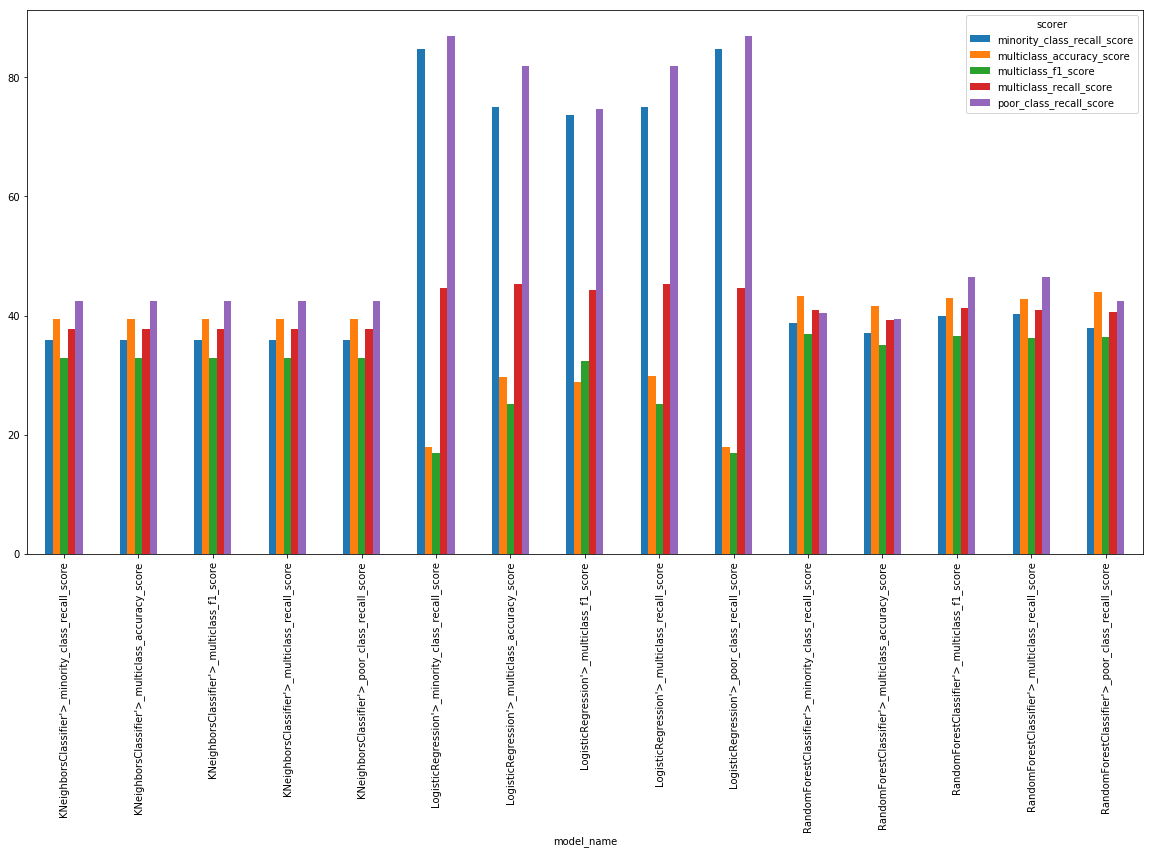

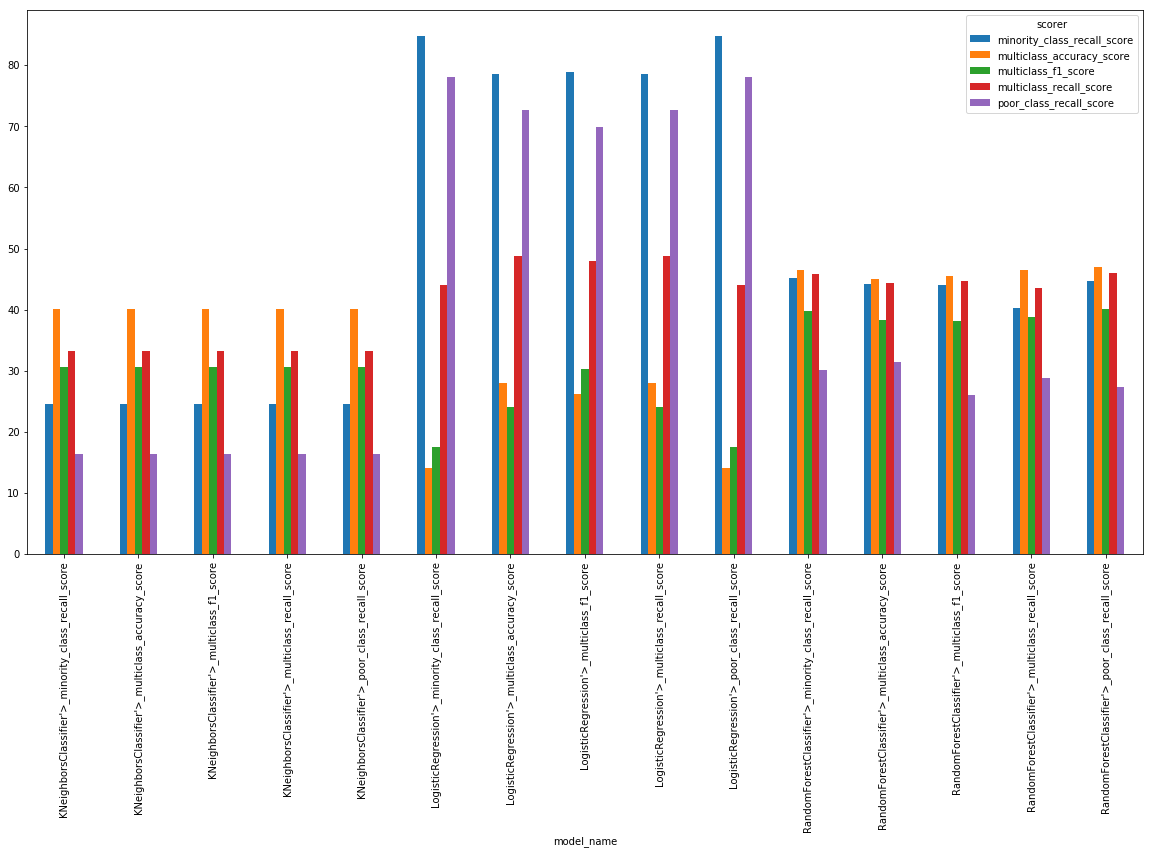

In [18]:
# display test data scores for other years by running our best models on them
for df_plot1 in df_plots.values():
    df1 = df_plot1.pivot(index='model_name', columns='scorer', values='scores')
    df1.plot(kind='bar',figsize=(20, 10))

## Testing the solution : Identify schools that need ofsted manual inspection the most, for 2015-2016 and 2017-2018.

schools to visit 2015-2016
schools to visit 2017-2018


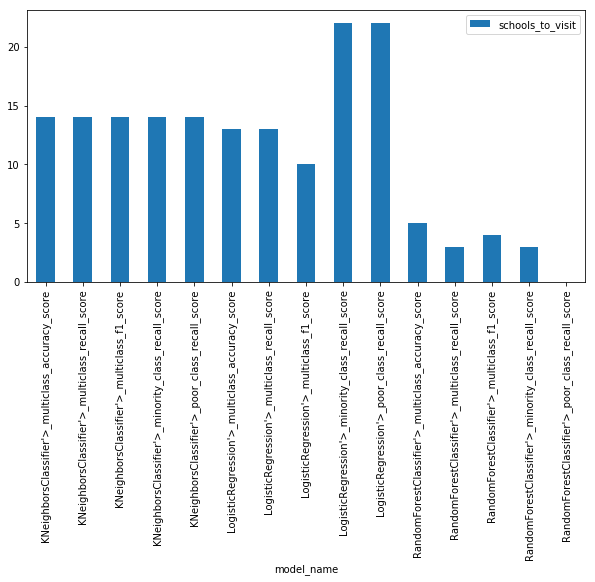

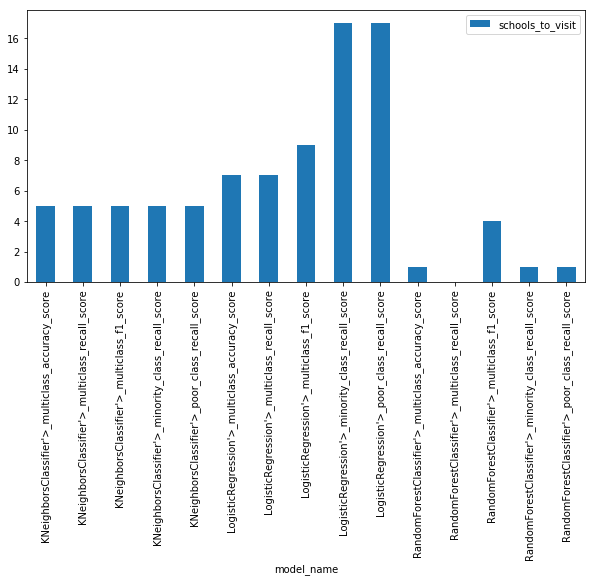

In [19]:
for year,predicted_school_df in df_school_visit_plots.items():
    no_of_schools_to_visit_values=[]
    ofsted_gap_threshold=3
    for model_name,df in predicted_school_df.items():
        df['ofsted_gap']=abs(df['ofsted_predicted']-df['ofsted'])
        no_of_schools_to_visit=(df[df['ofsted_gap']>=ofsted_gap_threshold].shape)[0]
        no_of_schools_to_visit_values=no_of_schools_to_visit_values+[no_of_schools_to_visit]

    df_visit_plot= pd.DataFrame(columns=['model_name','schools_to_visit'])
    df_visit_plot['model_name']=predicted_school_df.keys()
    df_visit_plot['schools_to_visit']=no_of_schools_to_visit_values

    print(f"schools to visit {year}")
    df_visit_plot.set_index('model_name',inplace=True)
    df_visit_plot.plot(kind='bar',figsize=(10, 5))